In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('campeonato-brasileiro-full.csv')
df.head()

df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7645 entries, 0 to 7644
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  7645 non-null   int64 
 1   rodada              7645 non-null   int64 
 2   data                7645 non-null   object
 3   hora                7645 non-null   object
 4   dia                 7645 non-null   object
 5   mandante            7645 non-null   object
 6   visitante           7645 non-null   object
 7   formacao_mandante   2671 non-null   object
 8   formacao_visitante  2671 non-null   object
 9   tecnico_mandante    3035 non-null   object
 10  tecnico_visitante   3035 non-null   object
 11  vencedor            7645 non-null   object
 12  arena               7645 non-null   object
 13  mandante_placar     7645 non-null   int64 
 14  visitante_placar    7645 non-null   int64 
 15  mandante_estado     7645 non-null   object
 16  visitante_estado    7645

ID                       0
rodada                   0
data                     0
hora                     0
dia                      0
mandante                 0
visitante                0
formacao_mandante     4974
formacao_visitante    4974
tecnico_mandante      4610
tecnico_visitante     4610
vencedor                 0
arena                    0
mandante_placar          0
visitante_placar         0
mandante_estado          0
visitante_estado         0
estado_vencedor          0
dtype: int64

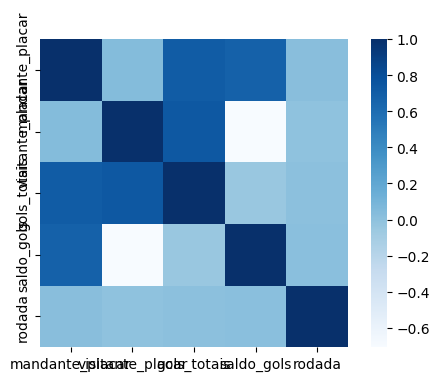

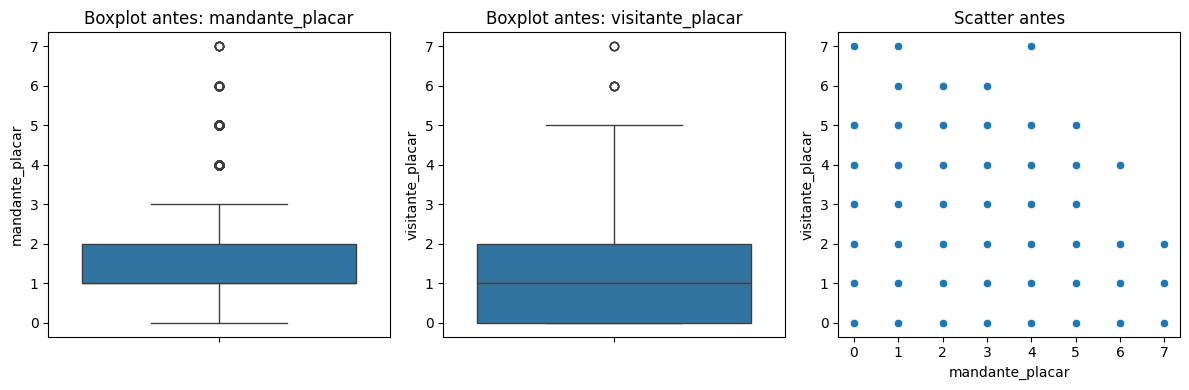

Resumo da remoção de outliers (método IQR):
mandante_placar: removidos=547 | limites=(-0.50, 3.50) | Q1=1.00 Q3=2.00
visitante_placar: removidos=7 | limites=(-3.00, 5.00) | Q1=0.00 Q3=2.00


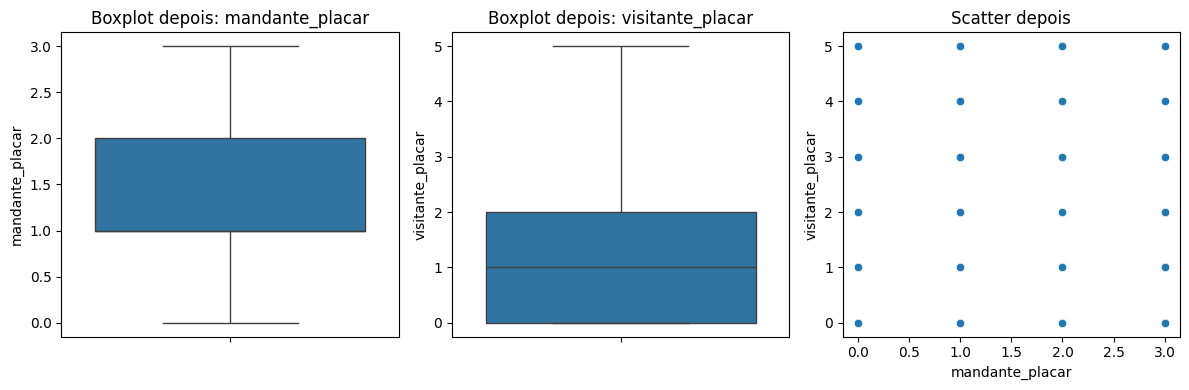

Correlação (Pearson) entre placares após limpeza: 0.043


In [27]:
# Análise de outliers para mandante_placar e visitante_placar usando IQR
cols = ['mandante_placar','visitante_placar']

# 1. Visualização inicial (boxplots + scatter)
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i, c in enumerate(cols):
    sns.boxplot(y=df[c], ax=axes[i])
    axes[i].set_title(f'Boxplot antes: {c}')
sns.scatterplot(data=df, x='mandante_placar', y='visitante_placar', ax=axes[2])
axes[2].set_title('Scatter antes')
plt.tight_layout()
plt.show()

# 2. Função para filtrar outliers via IQR
def iqr_filter(frame, column, k=1.5):
    Q1 = frame[column].quantile(0.25)
    Q3 = frame[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - k * IQR
    high = Q3 + k * IQR
    mask = (frame[column] >= low) & (frame[column] <= high)
    removed = (~mask).sum()
    return frame[mask], {
        'col': column,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'low': low,
        'high': high,
        'removed': removed
    }

stats = []
df_clean = df.copy()
for c in cols:
    df_clean, st = iqr_filter(df_clean, c)
    stats.append(st)

print('Resumo da remoção de outliers (método IQR):')
for st in stats:
    print(f"{st['col']}: removidos={st['removed']} | limites=({st['low']:.2f}, {st['high']:.2f}) | Q1={st['Q1']:.2f} Q3={st['Q3']:.2f}")

# 3. Visualização após limpeza
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i, c in enumerate(cols):
    sns.boxplot(y=df_clean[c], ax=axes[i])
    axes[i].set_title(f'Boxplot depois: {c}')
sns.scatterplot(data=df_clean, x='mandante_placar', y='visitante_placar', ax=axes[2])
axes[2].set_title('Scatter depois')
plt.tight_layout()
plt.show()

# 4. Correlação
corr = df_clean['mandante_placar'].corr(df_clean['visitante_placar'])
print(f"Correlação (Pearson) entre placares após limpeza: {corr:.3f}")

# 5. Atualiza df principal
df = df_clean

# Observação: ajuste k na função iqr_filter (ex.: k=3) se quiser ser mais conservador na remoção.

Contagem de possíveis outliers por coluna (|z|>3):
mandante_placar      0
visitante_placar    19
rodada               0
dtype: int64
Colunas categóricas de baixa cardinalidade selecionadas para one-hot: ['dia', 'mandante_estado', 'visitante_estado']
Matriz de correlação (valores numéricos):
                  mandante_placar  visitante_placar  gols_totais  saldo_gols  \
mandante_placar          1.000000          0.043370     0.708269    0.675647   
visitante_placar         0.043370          1.000000     0.735996   -0.707228   
gols_totais              0.708269          0.735996     1.000000   -0.041898   
saldo_gols               0.675647         -0.707228    -0.041898    1.000000   
rodada                   0.020513         -0.004733     0.010555    0.018009   

                    rodada  
mandante_placar   0.020513  
visitante_placar -0.004733  
gols_totais       0.010555  
saldo_gols        0.018009  
rodada            1.000000  


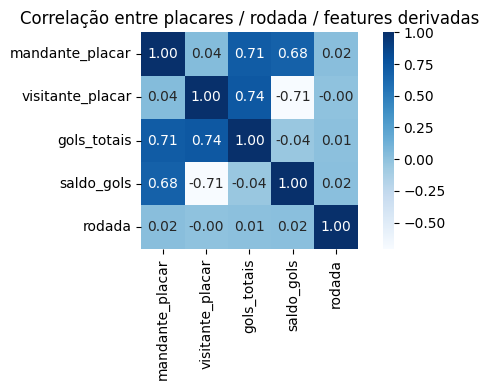

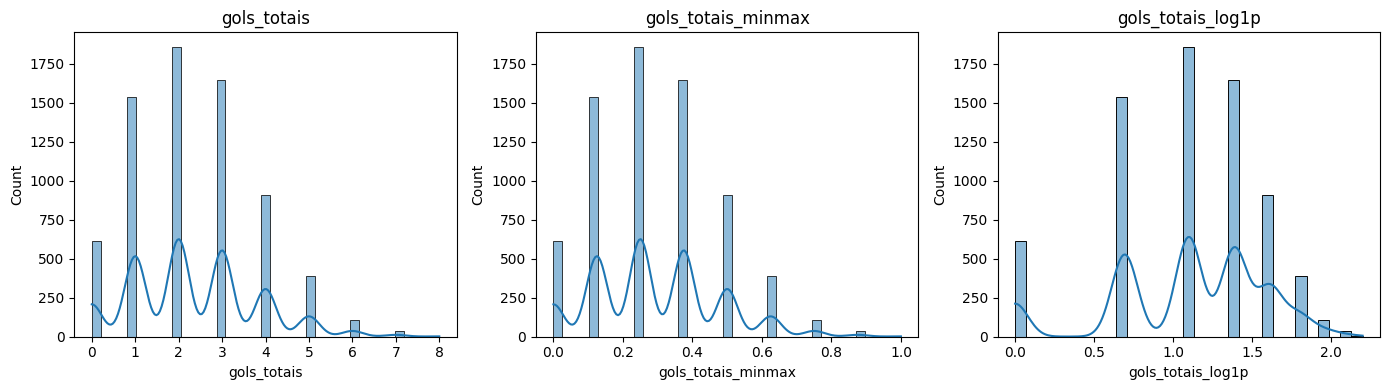

Shape original: (7091, 22) | Shape codificada: (7091, 53)


In [28]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# 1. Escolher colunas numéricas relevantes
numeric_cols = ['mandante_placar','visitante_placar']
if 'rodada' in df.columns:
    numeric_cols.append('rodada')

num_df = df[numeric_cols].copy()

# 2. Z-score (para cada coluna numérica)
z_scores = num_df.apply(lambda s: stats.zscore(s, nan_policy='omit'))
z_flag = (z_scores.abs() > 3)  # boolean indicating potential outliers
print('Contagem de possíveis outliers por coluna (|z|>3):')
print(z_flag.sum())

# 3. Feature engineering: gols totais e diferença de gols
if all(c in df.columns for c in ['mandante_placar','visitante_placar']):
    df['gols_totais'] = df['mandante_placar'] + df['visitante_placar']
    df['saldo_gols'] = df['mandante_placar'] - df['visitante_placar']

# 4. Normalização Min-Max e Log1p para gols_totais
scaler = MinMaxScaler()
if 'gols_totais' in df.columns:
    df['gols_totais_minmax'] = scaler.fit_transform(df[['gols_totais']])
    df['gols_totais_log1p'] = np.log1p(df['gols_totais'])

# 5. Codificação de variáveis categóricas (exemplos comuns do dataset)
# Vamos detectar automaticamente algumas colunas categóricas de baixo cardinalidade
potential_cat = [c for c in df.columns if df[c].dtype == 'object']
low_card_cat = [c for c in potential_cat if df[c].nunique() <= 15]  # limite arbitrário
print('Colunas categóricas de baixa cardinalidade selecionadas para one-hot:', low_card_cat)

# One-hot encoding controlado
df_encoded = pd.get_dummies(df, columns=low_card_cat, drop_first=True)

# 6. Matriz de correlação entre placares, rodada e novas features
corr_cols = [c for c in ['mandante_placar','visitante_placar','gols_totais','saldo_gols','rodada'] if c in df_encoded.columns]

corr_matrix = df_encoded[corr_cols].corr()
print('Matriz de correlação (valores numéricos):')
print(corr_matrix)

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', square=True)
plt.title('Correlação entre placares / rodada / features derivadas')
plt.tight_layout()
plt.show()

# 7. Visual comparativa distribuições (original vs transformada) se gols_totais criado
if 'gols_totais' in df.columns:
    fig, axes = plt.subplots(1,3, figsize=(14,4))
    sns.histplot(df['gols_totais'], kde=True, ax=axes[0])
    axes[0].set_title('gols_totais')
    sns.histplot(df['gols_totais_minmax'], kde=True, ax=axes[1])
    axes[1].set_title('gols_totais_minmax')
    sns.histplot(df['gols_totais_log1p'], kde=True, ax=axes[2])
    axes[2].set_title('gols_totais_log1p')
    plt.tight_layout()
    plt.show()

# Atualiza df principal para versão codificada se necessário
# (Se quiser manter apenas numéricas + dummies):
# df = df_encoded

print('Shape original:', df.shape, '| Shape codificada:', df_encoded.shape)


In [ ]:
# 1. Conversão de datas e features derivadas
possible_date_cols = [c for c in df.columns if 'data' in c.lower() or 'date' in c.lower()]
print('Possíveis colunas de data encontradas:', possible_date_cols)

for c in possible_date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True)
    except Exception as e:
        print(f'Falha ao converter {c}:', e)

# Criar colunas derivadas para a primeira coluna de data válida
if possible_date_cols:
    date_col = possible_date_cols[0]
    if pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df['ano'] = df[date_col].dt.year
        df['mes'] = df[date_col].dt.month
        df['dia_semana'] = df[date_col].dt.day_name(locale='pt_BR') if hasattr(df[date_col].dt, 'day_name') else df[date_col].dt.dayofweek
        print(f'Colunas derivadas criadas a partir de {date_col}.')
    else:
        print('Nenhuma coluna de data válida para derivação.')
else:
    print('Nenhuma coluna potencial de data encontrada.')

In [ ]:
# 2. Funções de filtragem por time mandante/visitante ou árbitro

def filtrar(df_base, mandante=None, visitante=None, arbitro=None):
    dff = df_base.copy()
    if mandante and 'mandante' in dff.columns:
        dff = dff[dff['mandante'] == mandante]
    if visitante and 'visitante' in dff.columns:
        dff = dff[dff['visitante'] == visitante]
    if arbitro and ('arbitro' in dff.columns or 'árbitro' in dff.columns):
        arb_col = 'arbitro' if 'arbitro' in dff.columns else 'árbitro'
        dff = dff[dff[arb_col] == arbitro]
    return dff

# 3. Lista de valores únicos para auxiliar seleção manual
for col in ['mandante','visitante','arbitro','árbitro']:
    if col in df.columns:
        print(f'Valores únicos em {col} (primeiros 15):', df[col].dropna().unique()[:15])

# Exemplo de uso (ajuste manualmente os nomes reais):
exemplo_df = filtrar(df, mandante=None, visitante=None, arbitro=None)
print('Registros após filtro de exemplo:', len(exemplo_df))

In [ ]:
# 4. Função para scatter plot filtrado

def scatter_placares(df_base, mandante=None, visitante=None, arbitro=None, hue=None):
    dff = filtrar(df_base, mandante, visitante, arbitro)
    if dff.empty:
        print('Nenhum registro após filtros.')
        return
    plt.figure(figsize=(6,5))
    if hue and hue in dff.columns:
        sns.scatterplot(data=dff, x='mandante_placar', y='visitante_placar', hue=hue, palette='tab10')
    else:
        sns.scatterplot(data=dff, x='mandante_placar', y='visitante_placar', color='steelblue')
    plt.title('Scatter: mandante_placar vs visitante_placar')
    plt.xlabel('Mandante Placar')
    plt.ylabel('Visitante Placar')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# Exemplo simples (sem filtros):
scatter_placares(df)


In [ ]:
# 5. (Opcional) Widgets interativos se ipywidgets estiver instalado
try:
    import ipywidgets as widgets
    from IPython.display import display
    mandantes = sorted(df['mandante'].dropna().unique()) if 'mandante' in df.columns else []
    visitantes = sorted(df['visitante'].dropna().unique()) if 'visitante' in df.columns else []
    arbitros = sorted(df['arbitro'].dropna().unique()) if 'arbitro' in df.columns else (sorted(df['árbitro'].dropna().unique()) if 'árbitro' in df.columns else [])

    mandante_w = widgets.Dropdown(options=[''] + mandantes, description='Mandante:')
    visitante_w = widgets.Dropdown(options=[''] + visitantes, description='Visitante:')
    arbitro_w = widgets.Dropdown(options=[''] + arbitros, description='Árbitro:')
    hue_w = widgets.Dropdown(options=[''] + [c for c in ['ano','mes','rodada'] if c in df.columns], description='Hue:')
    out_box = widgets.Output()

    def update_plot(*args):
        out_box.clear_output()
        with out_box:
            scatter_placares(df,
                             mandante=mandante_w.value or None,
                             visitante=visitante_w.value or None,
                             arbitro=arbitro_w.value or None,
                             hue=hue_w.value or None)

    for w in [mandante_w, visitante_w, arbitro_w, hue_w]:
        w.observe(update_plot, names='value')

    display(widgets.HBox([mandante_w, visitante_w]))
    display(widgets.HBox([arbitro_w, hue_w]))
    display(out_box)
    update_plot()
except ImportError:
    print('ipywidgets não instalado - pulei interface interativa.')

In [ ]:
# 6. Exportação do dataframe final tratado
output_filename = 'campeonato-brasileiro-tratado.csv'
df.to_csv(output_filename, index=False, encoding='utf-8')
print(f'Dataframe exportado para {output_filename} (linhas={len(df)})')

In [ ]:
# 1. Colunas derivadas de resultado
required_cols = {'mandante','visitante','mandante_placar','visitante_placar'}
if required_cols.issubset(set(df.columns)):
    df['resultado'] = np.where(df['mandante_placar'] > df['visitante_placar'], 'mandante',
                        np.where(df['mandante_placar'] < df['visitante_placar'], 'visitante', 'empate'))
    df['vencedor'] = np.where(df['resultado'] == 'empate', 'empate',
                       np.where(df['resultado'] == 'mandante', df['mandante'], df['visitante']))
    print('Colunas resultado e vencedor criadas.')
else:
    print('Não foi possível criar colunas de resultado: faltam colunas necessárias.')

# 2. Número de vitórias por time (considerando mandante e visitante)
if 'vencedor' in df.columns:
    vitorias = df[df['vencedor'] != 'empate'].groupby('vencedor').size().rename('vitorias').to_frame()
else:
    vitorias = pd.DataFrame()

# 3. Empates por time (cada time que participou do empate conta 1)
if 'resultado' in df.columns and 'mandante' in df.columns and 'visitante' in df.columns:
    empates_mand = df[df['resultado']=='empate'].groupby('mandante').size()
    empates_visit = df[df['resultado']=='empate'].groupby('visitante').size()
    empates = (empates_mand.add(empates_visit, fill_value=0)).rename('empates')
else:
    empates = pd.Series(dtype='int64')

# 4. Jogos disputados por time
if {'mandante','visitante'}.issubset(df.columns):
    jogos_mand = df.groupby('mandante').size()
    jogos_visit = df.groupby('visitante').size()
    jogos = jogos_mand.add(jogos_visit, fill_value=0).rename('jogos')
else:
    jogos = pd.Series(dtype='int64')

# 5. Gols pró e contra por time
if required_cols.issubset(df.columns):
    gols_pro_mand = df.groupby('mandante')['mandante_placar'].sum()
    gols_pro_visit = df.groupby('visitante')['visitante_placar'].sum()
    gols_pro = gols_pro_mand.add(gols_pro_visit, fill_value=0).rename('gols_pro')

    gols_contra_mand = df.groupby('mandante')['visitante_placar'].sum()
    gols_contra_visit = df.groupby('visitante')['mandante_placar'].sum()
    gols_contra = gols_contra_mand.add(gols_contra_visit, fill_value=0).rename('gols_contra')
else:
    gols_pro = pd.Series(dtype='int64')
    gols_contra = pd.Series(dtype='int64')

# 6. Montagem do dataframe agregado
agregados = pd.concat([jogos, vitorias, empates, gols_pro, gols_contra], axis=1)
agregados.fillna(0, inplace=True)
if 'vitorias' in agregados.columns:
    agregados['taxa_vitoria'] = agregados['vitorias'] / agregados['jogos'].replace(0, np.nan)
if {'gols_pro','gols_contra'}.issubset(agregados.columns):
    agregados['saldo_gols_time'] = agregados['gols_pro'] - agregados['gols_contra']

agregados.sort_values(by='vitorias', ascending=False, inplace=True)
print('Resumo agregados (top 10):')
print(agregados.head(10))


In [ ]:
# 7. Gráficos de barras (Top N)
if not agregados.empty:
    top_n = 15
    fig, axes = plt.subplots(1,3, figsize=(18,5))

    # Vitórias
    agregados.nlargest(top_n, 'vitorias')['vitorias'].plot(kind='bar', ax=axes[0], color='royalblue')
    axes[0].set_title('Top Vitórias')
    axes[0].set_ylabel('Vitórias')

    # Saldo de gols
    if 'saldo_gols_time' in agregados.columns:
        agregados.nlargest(top_n, 'saldo_gols_time')['saldo_gols_time'].plot(kind='bar', ax=axes[1], color='seagreen')
        axes[1].set_title('Top Saldo de Gols')

    # Taxa de vitória
    if 'taxa_vitoria' in agregados.columns:
        (agregados['taxa_vitoria']*100).nlargest(top_n).plot(kind='bar', ax=axes[2], color='darkorange')
        axes[2].set_title('Top Taxa de Vitória (%)')

    for ax in axes:
        ax.tick_params(axis='x', rotation=75)
    plt.tight_layout()
    plt.show()
else:
    print('Dados agregados vazios, não gerando gráficos.')

In [ ]:
# 8. Heatmap de correlação entre métricas agregadas
if not agregados.empty:
    metric_cols = [c for c in ['jogos','vitorias','empates','gols_pro','gols_contra','saldo_gols_time','taxa_vitoria'] if c in agregados.columns]
    corr_ag = agregados[metric_cols].corr()
    print('Correlação entre métricas agregadas:')
    print(corr_ag)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_ag, annot=True, cmap='magma', fmt='.2f', square=True)
    plt.title('Heatmap Correlação Métricas de Times')
    plt.tight_layout()
    plt.show()
else:
    print('Sem dados agregados para correlação.')